In [3]:
import numpy as np
import torch
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

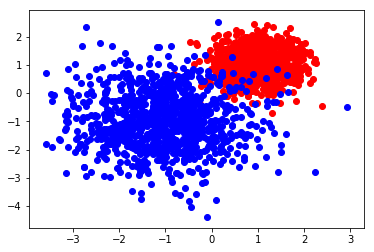

In [4]:
numpc = 1000
points1 = torch.randn(numpc,2)*.5+1
points2 = torch.randn(numpc,2)-1

plt.scatter(points1[:,0], points1[:,1], color='red')
plt.scatter(points2[:,0], points2[:,1], color='blue')
points = torch.cat((points1, points2), dim=0)
labels = np.zeros(2*numpc)
labels[1000:]=1

In [5]:
init = np.array([[-5.,0],[0, -5.]])
kmeans = KMeans(n_clusters=2, random_state=0, init = init).fit(points)

/u/gpandey1/anaconda3/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:896: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


In [15]:
accuracy = (kmeans.labels_==labels).sum()/len(labels)*100
if accuracy<50:
    accuracy = 100-accuracy
print("Accuracy of K-Means = {}%".format(accuracy))

Accuracy of K-Means = 95.85%


In [16]:
mu = torch.from_numpy(init).float()
#Compute the cluster associated with each point by evaluating q(x|c) and then q(c|x)
dist = torch.zeros(2*numpc,2)
dist[:,0] = ((points - mu[0].unsqueeze(0))**2).sum(1)
dist[:,1] = ((points - mu[1].unsqueeze(0))**2).sum(1)

#Evaluate q(x|c=0) and q(x|c=1)
qx_c = (dist*-1).exp()
qx_c = qx_c/qx_c.sum(0, keepdim=True)

clus_num = qx_c.max(1)[1]

In [17]:
for iter in range(10000):
    mask = (clus_num==0).unsqueeze(1)
    mu_hard0 = (points*mask.float()).sum(0)/mask.sum()
    mu_soft0 = (points*qx_c[:,0].unsqueeze(1)).sum(0)
    mu[0] = mu[0] + .1*(mu_hard0-mu_soft0)

    mask = (clus_num==1).unsqueeze(1)
    mu_hard1 = (points*mask.float()).sum(0)/mask.sum()
    mu_soft1 = (points*qx_c[:,1].unsqueeze(1)).sum(0)
    mu[1] = mu[1] + .1*(mu_hard1-mu_soft1)

    #Compute the cluster associated with each point by evaluating q(x|c) and then q(c|x)
    dist[:,0] = ((points - mu[0].unsqueeze(0))**2).sum(1)
    dist[:,1] = ((points - mu[1].unsqueeze(0))**2).sum(1)

    #Evaluate q(x|c=0) and q(x|c=1)
    qx_c = (dist*-1).exp()
    qx_c = qx_c/qx_c.sum(0, keepdim=True)

    clus_num = qx_c.max(1)[1]

In [18]:
accuracy = (clus_num.numpy()==labels).sum()/len(labels)*100
if accuracy<50:
    accuracy = 100-accuracy
print("Accuracy of DisCoder={}".format(accuracy))

Accuracy=96.3
